In [1]:
#%%bash
#pip install mpld3

In [2]:
%%bash
pip install -U scikit-learn

  Using cached scikit_learn-0.18.1-cp27-cp27mu-manylinux1_x86_64.whl


You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np

import os
import inspect
import sys
import pandas as pd
import charts
import time

from opengrid.library import houseprint

from scipy.signal import butter, lfilter, freqz

from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean at 127.0.0.1:49327


In [4]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
30 Sites created
30 Devices created
87 sensors created
Houseprint parsing complete


In [5]:
device = hp.find_device('FL03001441')
device.get_sensors()

[
     Fluksosensor
     Key: 81fb589c911e808daa96a2064bebed41
     Type: electricity
     , 
     Fluksosensor
     Key: 212ce724e124fbde0fb649396375d099
     Type: gas
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: 156e0abc64b00c5e98dbd3c17883b5f6
     Type: electricity
     , 
     Fluksosensor
     Key: e5306ee3a4235498592fc89ee0ede353
     Type: electricity
     ]

In [6]:
#Get Electricity data
head = pd.Timestamp('2015-11-17 01:00:00')
tail = pd.Timestamp('2015-11-19 01:00:00')
electr = hp.find_sensor('81fb589c911e808daa96a2064bebed41')
df_el = electr.get_data(head,tail,diff=True, unit='W')
df_el = df_el.dropna()

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [7]:
#Get Gas data
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')
df_ga = gas.get_data(head,tail,diff=True)
df_ga = df_ga.fillna(0)

In [8]:
#Get Water data
water = hp.find_sensor('c57f45b21e2ec21ab427f172478e1ca4')
df_wa = water.get_data(head,tail,diff=True)
df_wa = df_wa.dropna()

In [9]:
df_ga_diff = df_ga.diff()
result = pd.concat([df_ga, df_ga_diff], axis=1).dropna()
result.columns = ['gas', 'diff']

In [10]:
charts.plot(result, show="inline", stock=True)

In [11]:
diff_max_tresh = df_ga_diff.max() * 0.2
diff_min_tresh = df_ga_diff.min() * 0.2

In [12]:
for i in range(0, df_ga_diff.size):
    if df_ga_diff[i] < diff_max_tresh and df_ga_diff[i] > diff_min_tresh:
        df_ga_diff[i] = 0

In [13]:
result = pd.concat([df_ga, df_ga_diff], axis=1).dropna()
result.columns = ['gas', 'diff']

In [14]:
charts.plot(result, show="inline", stock=True)

In [15]:
point_type = 'none'
minmax = pd.DataFrame(columns=['value', 'type'])

next_index = df_ga_diff.index[df_ga_diff.size - 1] + 1
temp = pd.Series(data=[0], index=[next_index])
df_ga_diff = df_ga_diff.append(temp)

for i in range(1, df_ga_diff.size-1):
    if df_ga_diff[i] > 0:
        if df_ga_diff[i] > df_ga_diff[i+1] and df_ga_diff[i] > df_ga_diff[i-1]:
            point_type = 'max'
            
        else:
            point_type = 'none'
    
    elif df_ga_diff[i] < 0:
        if df_ga_diff[i] < df_ga_diff[i+1] and df_ga_diff[i] < df_ga_diff[i-1]:
            point_type = 'min'
            
        else:
            point_type = 'none'
    
    else:
        point_type = 'none'
            
    
    if point_type == 'max' or point_type == 'min':
        temp = pd.DataFrame(data=[[df_ga_diff[i], point_type]], index=[df_ga_diff.index[i]], columns=['value', 'type'])
        minmax = minmax.append(temp)
        

In [16]:
def getValueBetween(ts_one, ts_two):
    middle = (ts_two - ts_one)
    if (middle.seconds/60) %2 == 0:
        middle = ts_one + (ts_two - ts_one)/2
    else:
        middle = ts_one + (ts_two - ts_one + ('0 days 00:01:00'))/2

    consumption_between = df_ga.get_value(middle)
    return consumption_between

In [17]:
events = pd.DataFrame(columns=['start', 'stop'])
unassigned_maxima = pd.DataFrame(columns=['value'])
unassigned_minima = pd.DataFrame(columns=['value'])

#Pseudocode in comments

#TODO: detect baseline automatically
baseline = 1000
max_value = df_ga.max()
last_index_prev_block = 0

#append a 0 at the end to prevent index from going out of bounds
if minmax['type'][minmax['type'].size - 1] != 'none':
    temp = pd.DataFrame(data=[[0, 'none']], index=[df_ga.index[df_ga.size-1]], columns=['value', 'type'])
    minmax = minmax.append(temp)

#Iterate through all the on- and off-events
for i in range(0, minmax['value'].size-1):
    
    #If an on-event occurs store it in a 'pending'-list
    if minmax['type'][i] == 'max':
        temp = pd.DataFrame(data=[minmax['value'][i]], index=[minmax.index[i]], columns=['value'])
        unassigned_maxima = unassigned_maxima.append(temp)
    
    #If an off-event occurs, match it with the correct on-event
    elif minmax['type'][i] == 'min':
        #There are a few possible patterns:
            #1: A clear on-off block
            #2: Multiple devices turning on at the same time
            #3: Multiple devices turning off at the same time
            
        
        #There are multiple off event that need to be matched with their corresponding on-event
        #We will store the off events in a list untill we reach the baseline again
        temp = pd.DataFrame(data=[minmax['value'][i]], index=[minmax.index[i]], columns=['value'])
        unassigned_minima = unassigned_minima.append(temp)
            
        #Get consumptionlevel after event
        ts_this = minmax.index[i]
        ts_next = minmax.index[i+1]
        consumption_after_min = getValueBetween(ts_this, ts_next)
        
        if consumption_after_min < baseline or i == minmax['value'].size-2:
            print "Baseline reached after ", minmax.index[i]
            
            #We've reached the baseline again. This means all pending events (min and max) need to be matched
            if unassigned_maxima.size == 1:
                #only one on-event: it needs to be matched with all off-events
                '''
                for j in range(0, unassigned_minima.size):
                    temp = pd.DataFrame(data=[[str(unassigned_maxima.index[0]), str(unassigned_minima.index[j])]], columns=['start', 'stop'])
                    events = events.append(temp)
                '''
                temp = pd.DataFrame(data=[[str(unassigned_maxima.index[0]), str(unassigned_minima.index[unassigned_minima.size-1])]], columns=['start', 'stop'])
                events = events.append(temp)
                
            elif unassigned_minima.size == 1:
                #only one off-event: it needs to be matched with all on-events
                '''
                for j in range(0, unassigned_maxima.size):
                    temp = pd.DataFrame(data=[[str(unassigned_maxima.index[j]), str(unassigned_minima.index[0])]], columns=['start', 'stop'])
                    events = events.append(temp)
                '''
                if unassigned_maxima.size > 0:
                    temp = pd.DataFrame(data=[[str(unassigned_maxima.index[0]), str(unassigned_minima.index[0])]], columns=['start', 'stop'])
                    events = events.append(temp)
                    
            
            elif unassigned_minima.size > 1 and unassigned_maxima.size > 1:
                #Multiple on- and off-events that need to be matched
                print"multiple on- and off-events"
                
                #######################################################################
                #             Match tops on block (ex. modulating fridge)             #
                #######################################################################
            
                #creat list with all on- off events of one block
                on_off_list = unassigned_maxima.append(unassigned_minima).sort_index()
                
                #prepend the last off-event of the previous block to be able to check for the value between the two
                if last_index_prev_block != 0:
                    temp = pd.DataFrame(data=[minmax['value'][last_index_prev_block]], index=[minmax.index[last_index_prev_block]], columns=['value'])
                    on_off_list = on_off_list.append(temp).sort_index()
                
                #Append two zero values behind the data to be able to check the last events without going out of bounds
                temp = pd.DataFrame(data=[0], index=[on_off_list.index[on_off_list.size-1]], columns=['value'])
                on_off_list = on_off_list.append(temp)
                on_off_list = on_off_list.append(temp)
                
                for j in range(1, on_off_list.size - 2):
                    if on_off_list['value'].iloc[j] > 0 and on_off_list['value'].iloc[j + 1] < 0:
                        #on followed by off: check if the level before and after is equal
                        level_before = getValueBetween(on_off_list.index[j-1], on_off_list.index[j])
                        level_after = getValueBetween(on_off_list.index[j+1], on_off_list.index[j+2])
                        
                        if (level_before > level_after - max_value * 0.1) and (level_before < level_after + max_value * 0.1):
                            #Level before and after peak is approximately the same
                            #match
                            temp = pd.DataFrame(data=[[str(on_off_list.index[j]), str(on_off_list.index[j+1])]], columns=['start', 'stop'])
                            events = events.append(temp)
                            #Replace by 0 to delete later
                            on_off_list['value'][j] = 0
                            #If it is the last (off-)event in the block it can't be deleted because it is also matched with another on-event
                            if j + 1 != on_off_list.size - 3:
                                on_off_list['value'][j+1] = 0
                            
                #Remove first (off-)event because it belongs to the previous block
                on_off_list['value'][0] = 0
                on_off_list = on_off_list[(on_off_list.T != 0).any()]
                
                '''
                #######################################################################
                #                  Match off-events that are certain                  #
                #######################################################################
                
                #A block always starts with an on-event. All following off-events (without on-event inbetween) are matched to this on-event
                j = 0
                next_event = on_off_list['value'].iloc[j + 1]
                #append a 0 at the end to prevent index going out of bounds
                temp = pd.DataFrame(data=[0], index=[on_off_list.index[on_off_list.size-1]], columns=['value'])
                on_off_list = on_off_list.append(temp)
                
                while next_event < 0:
                    temp = pd.DataFrame(data=[[str(on_off_list.index[0]), str(on_off_list.index[j+1])]], columns=['start', 'stop'])
                    events = events.append(temp)
                    
                    #if we reach the last event, this and the first one need to be removed
                    if j == on_off_list.size-3:
                        on_off_list['value'][0] = 0
                    
                    #off-event is matched => Remove it by replaceing it by 0 and later removing all 0's
                    on_off_list['value'][j+1] = 0
                    
                    j += 1
                    next_event = on_off_list['value'].iloc[j + 1]
                
                #Remove all matched off-events (0's)
                on_off_list = on_off_list[(on_off_list.T != 0).any()]
                
                #######################################################################
                #                  Match on-events that are certain                  #
                #######################################################################
                
                if on_off_list.size != 0:
                
                    #A block always ends with an off-event. All previous on-events (without off-event inbetween) are matched to this off-event
                    j = on_off_list.size - 1
                    prev_event = on_off_list['value'].iloc[j - 1]

                    #append a 0 at the start to prevent index going out of bounds
                    temp = pd.DataFrame(data=[0], index=[minmax.index[last_index_prev_block]], columns=['value'])
                    on_off_list = on_off_list.append(temp).sort_index()
                
                    while prev_event > 0:
                        temp = pd.DataFrame(data=[[str(on_off_list.index[j]), str(on_off_list.index[on_off_list.size-1])]], columns=['start', 'stop'])
                        events = events.append(temp)
                        
                        #if we reach the first event, this and the last one need to be removed
                        if j == 2:
                            on_off_list['value'][on_off_list.size-1] = 0
                            
                        #on-event is matched => Remove it by replaceing it by 0 and later removing all 0's
                        on_off_list['value'][j] = 0
                               
                        j = j - 1
                        prev_event = on_off_list['value'].iloc[j]
                        
                        
                    #Remove all matched off-events (0's)
                    on_off_list = on_off_list[(on_off_list.T != 0).any()]    
                            
                '''
                print on_off_list
              
            #Clear both lists
            unassigned_maxima = unassigned_maxima.ix[:-unassigned_maxima.size]
            unassigned_minima = unassigned_minima.ix[:-unassigned_minima.size]
            
            last_index_prev_block = i
            
events = events.sort_values('start')
print events

Baseline reached after  2015-11-17 05:49:00+00:00
Baseline reached after  2015-11-17 06:41:00+00:00
Baseline reached after  2015-11-17 07:13:00+00:00
Baseline reached after  2015-11-17 18:10:00+00:00
Baseline reached after  2015-11-17 18:34:00+00:00
multiple on- and off-events
                                 value
2015-11-17 18:22:00+00:00  6935.940023
2015-11-17 18:23:00+00:00 -4417.879418
2015-11-17 18:24:00+00:00  5775.467775
2015-11-17 18:34:00+00:00 -5191.214825
Baseline reached after  2015-11-17 18:54:00+00:00
multiple on- and off-events
                                 value
2015-11-17 18:44:00+00:00  2305.522143
2015-11-17 18:46:00+00:00  4862.168212
2015-11-17 18:47:00+00:00 -4516.789255
2015-11-17 18:48:00+00:00  6238.331678
2015-11-17 18:54:00+00:00 -5735.322120
Baseline reached after  2015-11-17 19:43:00+00:00
multiple on- and off-events
                                 value
2015-11-17 19:04:00+00:00  4381.868132
2015-11-17 19:05:00+00:00 -4175.824176
2015-11-17 19:13:00+

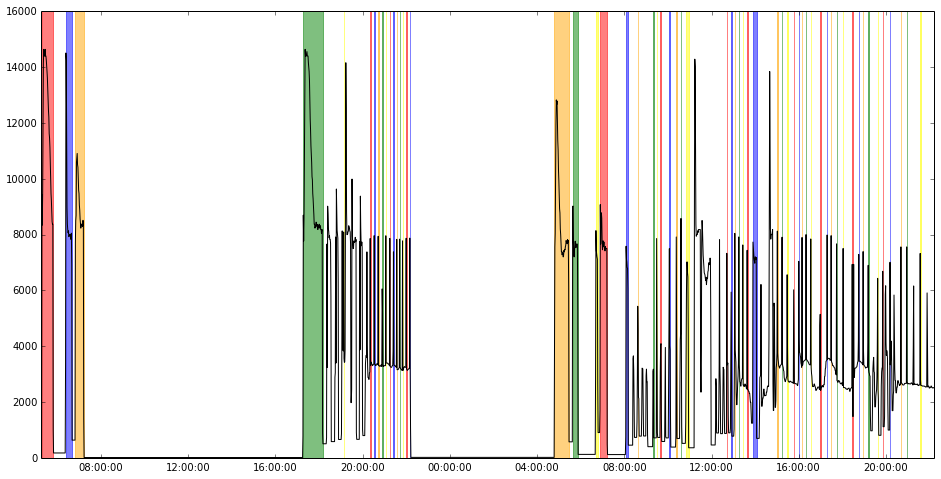

In [18]:
#%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

fig, ax = plt.subplots()
ax.plot(df_ga.index, df_ga, color='black')

colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


for i in range(0, events.index.size):
    ax.axvspan(events['start'].iloc[i], events['stop'].iloc[i], alpha=0.5, color=colors[i])

plt.show()

In [19]:
charts.plot(result, show="inline", stock=True)

In [20]:
characteristics = pd.DataFrame(columns=['total_cons', 'delta_t'])

for i in range(0, events.index.size):
    if pd.Timestamp(events['start'].iloc[i]) < pd.Timestamp(events['stop'].iloc[i]):
        
        #Get total consumption of block
        total = df_ga.ix[pd.Timestamp(events['start'].iloc[i]):pd.Timestamp(events['stop'].iloc[i])]
        end = df_ga[pd.Timestamp(events['stop'].iloc[i])]
        total = total.subtract(end).sum()
        
        #Get duration of block
        delta_t = pd.Timedelta(pd.Timestamp(events['stop'].iloc[i]) - pd.Timestamp(events['start'].iloc[i]))/pd.Timedelta(1, 's')
        
        #Insert in characteristics
        temp = pd.DataFrame(data=[[total, delta_t]], index=[i], columns=['total_cons', 'delta_t'])
        characteristics = characteristics.append(temp)


In [21]:
characteristics['total_cons'] = characteristics['total_cons']/characteristics['total_cons'].max()
characteristics['delta_t'] = characteristics['delta_t']/characteristics['delta_t'].max()

In [22]:
#convert pandas to np array
resultArray = characteristics.as_matrix()

In [23]:
#Run clustering Algorithm
ms = MeanShift()
ms.fit(resultArray)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_cluster = len(np.unique(labels))
colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']

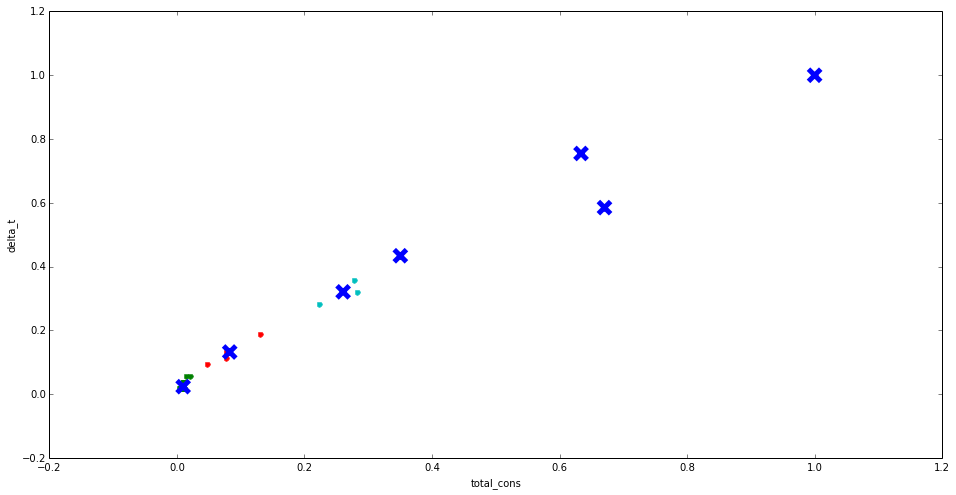

In [24]:
#Plot clusters
for i in range(len(resultArray)):
    plt.plot(resultArray[i][0], resultArray[i][1], colors[labels[i]], markersize = 10)

plt.scatter(cluster_centers[:,0],cluster_centers[:,1], marker = "x", s = 150, linewidths = 5, zorder = 10)
plt.xlabel('total_cons')
plt.ylabel('delta_t')
plt.show()

In [25]:
labels

array([3, 2, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 1, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
events.index = characteristics.index
df_lables = pd.DataFrame(data=labels, index=events.index, columns=['lable'])

In [27]:
events_lable = pd.concat([events, df_lables], axis=1)
events_lable

,start,stop,lable
0,2015-11-17 05:18:00+00:00,2015-11-17 05:49:00+00:00,3
1,2015-11-17 06:24:00+00:00,2015-11-17 06:41:00+00:00,2
2,2015-11-17 06:50:00+00:00,2015-11-17 07:13:00+00:00,4
3,2015-11-17 17:17:00+00:00,2015-11-17 18:10:00+00:00,6
4,2015-11-17 19:08:00+00:00,2015-11-17 19:09:00+00:00,0
5,2015-11-17 20:21:00+00:00,2015-11-17 20:22:00+00:00,0
6,2015-11-17 20:32:00+00:00,2015-11-17 20:33:00+00:00,0
7,2015-11-17 20:43:00+00:00,2015-11-17 20:44:00+00:00,0
8,2015-11-17 20:54:00+00:00,2015-11-17 20:56:00+00:00,0
9,2015-11-17 21:04:00+00:00,2015-11-17 21:05:00+00:00,0


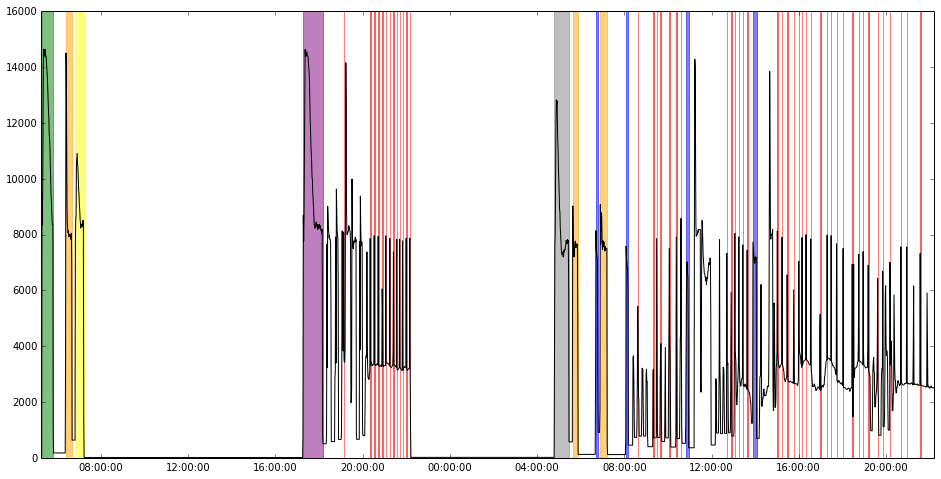

In [28]:
fig, ax = plt.subplots()
ax.plot(df_ga.index, df_ga, color='black')

colors = 100*['red', 'blue', 'orange', 'green', 'yellow', 'grey', 'purple']


for i in range(0, events_lable.index.size):
    ax.axvspan(events_lable['start'].iloc[i], events_lable['stop'].iloc[i], alpha=0.5, color=colors[events_lable['lable'].iloc[i]])

plt.show()

<h2>Define blocks for electricity consumption</h2>

In [29]:
df_el_diff = df_el.diff()
result = pd.concat([df_el, df_el_diff], axis=1)
result.columns = ['data', 'diff_data']
charts.plot(result, show="inline", stock=True)

<p>If the peaks are smaller than 19 they are omitted (replaced by 0)</p>

In [30]:
diff_max_tresh = 19
diff_min_tresh = -19

In [29]:
for i in range(0, df_el_diff.size):
    print df_el_diff[i]
    if df_el_diff[i] < diff_max_tresh and df_el_diff[i] > diff_min_tresh:
        print 0
        df_el_diff[i] = 0
        
    print '---------'

nan
---------
-3.46607341664
0
---------
-0.137931033969
0
---------
-1.80645161541
0
---------
-0.387096768245
0
---------
396.193548383
---------
-396.774193549
---------
0.838709680829
0
---------
-4.80938416673
0
---------
-4.16422287701
0
---------
6.98491930962e-09
0
---------
0.0
0
---------
1.8181818095
0
---------
-1.8181818095
0
---------
0.340909087099
0
---------
1.13636363531
0
---------
-1.4772727224
0
---------
1.81818181649
0
---------
-0.852272731718
0
---------
8.06818182115
0
---------
34.3749999977
---------
-3.69565216592
0
---------
5.10869564256
0
---------
2.60869565886
0
---------
-0.760869572405
0
---------
-1.08695651405
0
---------
1.84782607947
0
---------
0.496894419193
0
---------
9.08526255749
0
---------
-3.63636363298
0
---------
1.50762280449
0
---------
389.068322992
---------
-399.130434792
---------
2.60869565886
0
---------
-0.760869572405
0
---------
-7.66086955788
0
---------
-2.16153846821
0
---------
-26.567832164
---------
-10.2797202766
0
--

In [30]:
result = pd.concat([df_el, df_el_diff], axis=1)
result.columns = ['data', 'diff_data']
charts.plot(result, show="inline", stock=True)

In [31]:
point_type = 'none'
minmax = pd.DataFrame(columns=['value', 'type'])

next_index = df_el_diff.index[df_el_diff.size - 1] + 1
temp = pd.Series(data=[0], index=[next_index])
df_el_diff = df_el_diff.append(temp)

for i in range(1, df_el_diff.size-1):
    if df_el_diff[i] > 0:
        if df_el_diff[i] > df_el_diff[i+1] and df_el_diff[i] > df_el_diff[i-1]:
            point_type = 'max'
            
        else:
            point_type = 'none'
    
    elif df_el_diff[i] < 0:
        if df_el_diff[i] < df_el_diff[i+1] and df_el_diff[i] < df_el_diff[i-1]:
            point_type = 'min'
            
        else:
            point_type = 'none'
    
    else:
        point_type = 'none'
            
    
    if point_type == 'max' or point_type == 'min':
        temp = pd.DataFrame(data=[[df_el_diff[i], point_type]], index=[df_el_diff.index[i]], columns=['value', 'type'])
        minmax = minmax.append(temp)
    else:
        temp = pd.DataFrame(data=[[0, 'none']], index=[df_el_diff.index[i]], columns=['value', 'type'])
        minmax = minmax.append(temp)

In [32]:
result = pd.concat([df_el, minmax['value']], axis=1)
result.columns = ['data', 'diff_data']
charts.plot(result, show="inline", stock=True)